# Sounddevice and Soundfile in a Jupyter Notebooks

Author: DVC   
Date: 24/03/2021 
----

### Sounddevice - audio I/O fron audio devices
- is a Python wrapper around platform independent PortAudio with basic and advanced functionality
- is more advanced than PyAudio which is a more basic collection of python bindings to PortAudio
    + was the reference package, but may gradually loose traction relative to sounddevice

### Soundfile - audio I/O from file  
- is the core file audio I/O reference and used by other packages such as librosa, audiofile, a.o. 

### Contents
- contains examples from https://python-sounddevice.readthedocs.io/en/0.4.1/examples.html  and more
- contains a mini_player() app
- for advanced streaming functions, see sounddevice-streaming.ipynb

In [1]:
%matplotlib inline
import ipywidgets as widgets
import numpy as np
import argparse
import queue
import sys
import time

import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from collections import namedtuple
from IPython.display import display, clear_output, Audio, HTML
from urllib.parse import urlparse
from urllib.request import urlopen

from spectrogram_utils import *

In [2]:

help(spectrogram)

Help on function spectrogram in module spectrogram_utils:

spectrogram(y, samplerate=16000, frame_shift=10.0, frame_length=30.0, preemp=0.97, n_fft=512, window='hamm', output='dB', n_mels=None)
    spectrogram is a wrapper making use of the librosa() library with some adjustments:
        - frame positioning 
            centered at: k*n_shift + n_shift/2
            #frames:  n_samples // n_shift   , first and last frame partially artificial
        - edge processing (mirroring of input signal) similar to Kaldi / SPRAAK
        - pre-emphasis applied after edge processing
    
    required arguments:
      y       waveform data (numpy array) 
    
    optional arguments:
      samplerate   sample rate in Hz, default=16000
      frame_shift  frame shift in msecs, default= 10.0 msecs
      frame_length frame length in msecs, default= 30.0 msecs
      preemp       preemphasis coefficient, default=0.95
      window       window type, default='hamm'
      n_mels       number of mel channel

### 1. The Sound Device - querrying & setting basic properties

In [3]:
# all kinds of info, settings, defaults
print(sd.__version__)
print(sd.get_portaudio_version())
print(sd.query_devices())
sd.default.samplerate = 16000
sd.default.channels = 1
# default.channels =: number of channels in input, output
# default.dtype =: data type in input, output
print(sd.default.samplerate,sd.default.channels,sd.default.blocksize,sd.default.device,sd.default.dtype)

0.4.1
(1246720, 'PortAudio V19.6.0-devel, revision 396fe4b6699ae929d3a685b3ef8a7e97396139a4')
   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone Array (Intel® Smart , MME (2 in, 0 out)
   2 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  3 Speakers (Realtek(R) Audio), MME (0 in, 2 out)
   4 DELL U2414H (Intel(R) Display A, MME (0 in, 2 out)
   5 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   6 Microphone Array (Intel® Smart Sound Technology (Intel® SST)), Windows DirectSound (2 in, 0 out)
   7 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
   8 Speakers (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
   9 DELL U2414H (Intel(R) Display Audio), Windows DirectSound (0 in, 2 out)
  10 Speakers (Realtek(R) Audio), Windows WASAPI (0 in, 2 out)
  11 DELL U2414H (Intel(R) Display Audio), Windows WASAPI (0 in, 2 out)
  12 Microphone Array (Intel® Smart Sound Technology (Intel® SST)), Windows WASAPI (4 in, 0 out)
  13 Output (Intel(R) 

##### Suppress Extra Figure Title in widget plotting

### 2. Play from file

In [4]:
# audio_read() is a tiny wrapper around soundfile to read audio data from either local file or url
# - optionally return mono (first channel by default)
# - reading is done to 32bit float's in the range [-1.,1.]
def audio_read(resource,mono=False):
    parsed=urlparse(resource)
    if(parsed.scheme !=''):
        print(parsed.path)
        fp = io.BytesIO(urlopen(resource).read())
    else:
        print(parsed.scheme,parsed.path)
        fp = resource
    data, samplerate = sf.read(fp,dtype='float32')
    if (mono==False):          return(data,samplerate)
    elif (len(data.shape)==1): return(data,samplerate)
    else:                      return(data[:,0].flatten(),samplerate)

/~spchlab/data/13dB/pwhite.wav


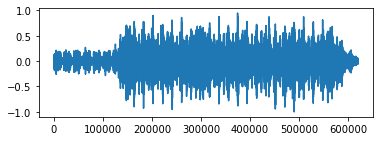

In [5]:
# read with soundfile and play with sounddevice
wavname = '../../sounds/maddigits/1.wav'
wavname = 'https://homes.esat.kuleuven.be/~spchlab/data/13dB/pwhite.wav'
# data, samplerate = sf.read(wavname,dtype='float32')
data,samplerate= audio_read(wavname,mono=True)
fig = plt.figure(figsize=(6,2))
plt.plot(data)
# if you want the plot above the audio widget, add line below
# plt.show()
Audio(data=data,rate=samplerate,autoplay=False)
# to play with sounddevice directly
# sd.play(data,samplerate)

### 3. Record and Playback

##### Notes on Audio Datastructures
- all apps use numpy arrays
- all 'play' apps work fine with 1D arrays
- **sounddevice.rec()** allways returns **2D arrays**, also for default one channel recordings   
    + be careful to FLATTEN such arrays for playback and usage in many other applications
    
##### Notes on APIs
- it is critical to include a call to **sd.wait()** to wait till recording is finished
- sounddevice and soundfile use similar arguments, but display.Audio may deviate
    + *samplerate* is used by sounddevice/soundfile , *rate* is used by Audio
    

recording started for 2.50 seconds
recording finished
converting to mono
playing ...


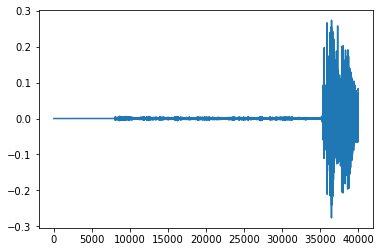

In [9]:
# audio_play() and audio_rec() 
# basic wrappers around sounddevice with typical speech defaults
#    mono (flattened), 16kHz, wait till recording is finished
def audio_play(data,samplerate=16000):
    print('playing ...')
    sd.play(data,samplerate)
def audio_rec(time=2.0,samplerate=16000,channels=1):
    data = sd.rec(int(time * samplerate),samplerate=samplerate,channels=channels)
    print('recording started for %.2f seconds' % time)
    sd.wait()  # waits for recording to complete, otherwise you get nonsense
    print('recording finished')
    if channels == 1:
        print('converting to mono')
        return(data.flatten())
    else: return(data)
#
samplerate=16000
data=audio_rec(time=2.5)
plt.plot(data)
# plt.show()
audio_play(data,samplerate)
#
Audio(data=data,rate=samplerate,normalize=False)

In [7]:
# you can also predefine/pre-allocate an array and reuse it for recordings
# note: 
#  (i) this will also be a 2D array 
#  (ii) the duration parameter is overwritten by the size of the array
#
dur=2.
data1d = np.zeros((100000,1))
print(data1d.shape)
sd.rec(int(dur * samplerate),samplerate=samplerate,out=data1d)
sd.wait()
print(data1d.shape)
sd.play(data1d,16000)

(100000, 1)
(100000, 1)


## 4. mini_player()  
A Record & Play interactive app with spectrogram view   


In [10]:
sd.default.samplerate = 16000
sd.default.channels = 1

Symbols = { 'play':'\u23F5','reverse':'\u23F4' , 'pause':'\u23F8', 'stop': '\u23F9', 'record':'\u23FA'}

def box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px'
     )

def button_layout():
    return widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px',
        width = '40px',
        height = '40px',
        flex_shrink =2
     )

class mini_player(widgets.HBox):
    
    def __init__(self,data=np.zeros((1000,)),samplerate=16000,figsize=(5,4)):
        super().__init__()
        
        self.data = data
        
        self.samplerate = samplerate
        self.rec_time = 2.0         
        self.line_color = '#0000ff'
        self.figsize = figsize
                     
        self.play_button = widgets.Button(description=Symbols['play'],layout=button_layout())
        self.record_button = widgets.Button(description=Symbols['record'],layout=button_layout())
        self.pause_button = widgets.Button(description=Symbols['pause'],layout=button_layout())
        self.clear_log_button = widgets.Button(description='Clear log')
        self.rec_time_slider = widgets.FloatSlider(value=self.rec_time,step=.5,min=.5,max=10.,
                                                   description='Rec Time',indent=False,continous_update=False)

        self.out = widgets.Output(layout=box_layout())
        self.logscr = widgets.Output()        
        self.UI = widgets.VBox([
            widgets.HBox([self.play_button,self.record_button,self.pause_button]),
            self.rec_time_slider,
            self.clear_log_button,
            self.logscr], 
            layout=box_layout())
       
        self.play_button.on_click(self.play_sound)       
        self.record_button.on_click(self.record_sound)        
        self.clear_log_button.on_click(self.clear_log_clicked)
        self.rec_time_slider.observe(self.rec_time_slider_observe,'value')
        
        self.fig, self.ax = plt.subplots(2,1,constrained_layout=True, figsize=self.figsize)
        self.plot_data()
        plt.close()
        
        # add to children
        self.children = [self.out, self.UI]  

    def plot_data(self):
        # draw the principle plots
        n_samples = len(self.data)
        if(n_samples < 1): return
        spg = spectrogram(self.data,samplerate=self.samplerate)
        self.fig=plot_spg(spg=[spg], wav=self.data, figsize=self.figsize, ShowPlot=False)    
        with self.logscr: pass
        with self.out:
            clear_output(wait=True)
            display(self.fig)
            
    def plot_data2(self):
        # draw the principle plots
        n_samples = len(self.data)
        if(n_samples < 1): return
        self.x = np.linspace(0.,n_samples/self.samplerate,n_samples,endpoint=False)
        self.ax[0].plot(self.x, self.data, self.line_color)
        self.ax[0].grid(True)
        self.ax[0].set_ylim(-1.,1.)
        spg_stft = librosa.stft(self.data,n_fft=512,hop_length=160,win_length=400)
        spg = librosa.power_to_db(np.abs(spg_stft)**2)
        self.ax[1].imshow(spg,cmap='jet',aspect='auto',origin='lower')        
        with self.out:
            clear_output(wait=True)
            display(self.fig)

    def rec_time_slider_observe(self,change):
        with self.logscr:
            print(change.new)
        self.rec_time = change.new
        self.update()
        
    def play_sound(self,b):
        with self.logscr:
            print("Playing")
        audio_play(self.data,self.samplerate) 
        #with self.widget_audio:
        #    ipd.clear_output()
        #    ipd.display(ipd.Audio(data=self.data,rate=self.samplerate)) 
    def record_sound(self,b):      
        with self.logscr:
            print("Recording for %.1f seconds"%self.rec_time)
        self.data = audio_rec(time=self.rec_time,samplerate=self.samplerate)
        #sd.wait()
        #self.data = recdata.flatten()
        with self.logscr:
            # ipd.clear_output()
            print('Recording Finished')
        sd.play(self.data,self.samplerate)
        self.plot_data()
        
    def clear_log_clicked(self,b):
        with self.logscr: clear_output()
            
player1 = mini_player(figsize=(12,6))
player1    

mini_player(children=(Output(layout=Layout(border='solid 1px black', margin='0px 10px 10px 0px', padding='5px …

## 5. Recording till interrupt


## 4. Streaming I/O

The example below shows streaming I/O   
Making a nice streaming plot is a challenge for the mpl-inline backend as full plots are refreshed each time
The intrinsic plot/refresh rates (on the order of 200msec on my PC), puts limits to the refresh rates that are possible and the
corresponding  'live' impression

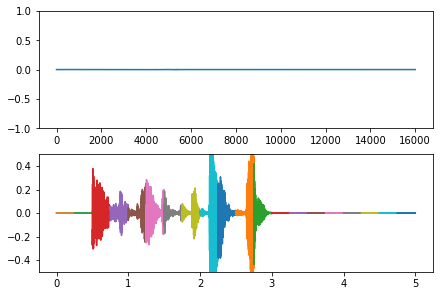

In [52]:
plt.close('all')
plt.clf()
# record and display in a streaming setup
# 
# blocksize  - size of buffer transferred via stream interface
# rec_time   - total recording time
# disp_time  - size of the display window
# 
samplerate = 16000
rec_time = 5.0    # record time in seconds
disp_time = 1.   # display time in seconds
block_time = .25  # length of recording buffer in seconds

blocksize = int(block_time*samplerate)
n_disp_blocks = int(disp_time/block_time)
n_rec_blocks = int(rec_time/block_time)
dispsize = blocksize*n_disp_blocks
recsize = blocksize*n_rec_blocks

#print(record_time,disp_time,blocksize,n_rec_blocks,n_disp_blocks)
#time.sleep(2)
buffer = np.zeros(blocksize)
disp_buffer = np.zeros(dispsize)
data = np.zeros((recsize))

x = np.linspace(0.,recsize/samplerate,recsize,endpoint=False)
q = queue.Queue()

out = widgets.Output(layout=box_layout())
logscr = widgets.Output(layout=box_layout())
fig2,ax = plt.subplots(2,1,constrained_layout=True)
ax[0].plot(x[0:dispsize],disp_buffer)
ax[0].set_ylim([-.5,.5])
ax[1].set_ylim([-.5,.5])
ax[1].plot(x,data)
plt.close()
#with out:
display(fig2)

# the .copy() is necessary to make this work !!
# the .flatten() is for convenience
def audio_callback(indata, frames, time, status):
    """This is called (from a separate thread) for each audio block."""
    if status:
        print(status, file=sys.stderr)
    q.put(indata.copy().flatten())

# InputStream() returns a numpy array
stream = sd.InputStream(blocksize=blocksize, samplerate=samplerate, callback=audio_callback)
    
with stream:
    print('recording starts !')
    for i in range(0, n_rec_blocks):
        #if i % 10 == 0:
        #    print('... ',i)
        # i0 = sample offset in recording buffer
        # i1 = current offset in display buffer
        i0 = i*blocksize
        i1 = i0 - dispsize + blocksize
        buffer = q.get()
        # roll the display buffer and add new data
        disp_buffer = np.roll(disp_buffer,-blocksize)
        disp_buffer[-blocksize:] = buffer.copy()
        data[i0:i0+blocksize]=buffer.copy()
        if( i1 >= 0):
            ax[0].cla()
            ax[0].plot(disp_buffer)
            ax[0].set_ylim([-1.,1.])
        ax[1].plot(x[i0:i0+blocksize],data[i0:i0+blocksize])
        clear_output(wait=True)
        display(fig2)
plt.close()


In [55]:
%%timeit -n 5
ax[0].plot(x,data)

3.29 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


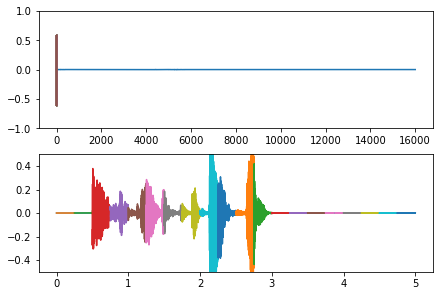

820 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [58]:
%%timeit -n 3
clear_output(wait=True)
display(fig2)

In [ ]:
print('\u22b3','\u25b6','\u25C0','\u220E','\u23F8','\u2b55','\u26AB')
print('\u23E9','\u23EA','\u23EB','\u23EC','\u23ED')
print('\u23F4','\u23F5','\u23F8','\u23F9','\u23FA')



In [ ]:
%%html
<font size=4> {"hi"} </font>

In [ ]:
mini_player(data=alldata)

In [ ]:
Audio(data=alldata.flatten(),rate=samplerate)

In [ ]:
plt.close('all')
# record and display in a streaming setup
# 
# frame  - number of samples in each I/O buffer
# time   - record time in seconds
# window - display window size
# 
# arguments (convert from dic to namedtuple)
args_dic={'samplerate':16000, 'frame':16000, 'time':3, 'window':16000, 'channels':1,'device':1,
          'filename':'dummy_rec.wav','subtype':'PCM_16' }
args = namedtuple("ArgsArgs",args_dic.keys())(*args_dic.values())
alldata = np.zeros(0)
q = queue.Queue()

# just puts the input data in the queue
# the .copy() is necessary to make this work !!
# the .flatten() is for convenience
def audio_callback(indata, frames, time, status):
    """This is called (from a separate thread) for each audio block."""
    if status:
        print(status, file=sys.stderr)
    q.put(indata.copy().flatten())
    
stream = sd.InputStream(samplerate=args.samplerate, device=args.device,
                        channels=args.channels, blocksize=args.frame, callback=audio_callback)

output = widgets.Output() 
with output:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
buffer = np.zeros(args.window)
line, = ax.plot(np.arange(0,args.window),buffer)
fig.canvas.toolbar_position = 'bottom'
ax.grid(True)
ax.set_ylim(-1.,1.)
display(output)
fig.canvas.flush_events()
    
out_box = widgets.Box([output])
output.layout = make_box_layout()

with stream:
    print('recording starts !')
    for i in range(0,args.time):
        print('... ',i)

        for j in range(0,args.samplerate//args.frame):
            buffer = np.roll(buffer,-args.frame)
            buffer[-args.frame:] = q.get()
            #[l.remove() for l in ax.lines]
            #line, = ax.plot(np.arange(0,args.window),buffer)
            #line.set_ydata(buffer)

            fig.canvas.draw()
            fig.canvas.flush_events()
        alldata = np.append(alldata,buffer)
        
display(Audio(data=alldata,rate=args.samplerate))
#plt.plot(alldata)
#plt.show()

In [ ]:
fig,ax = plt.subplots()
#display(fig)
plt.plot(range(0,10))
plt.show()
time.sleep(3)
print('sleeping finished')
plt.close(fig)
plt.show()

In [ ]:
fig = plt.figure()
display(fig)
for k in range(5):
    print(k)
    plt.clf()
    plt.plot([i for i in range(0,20,k+1)])
    fig.canvas.draw()
    time.sleep(1) #unnecessary, but useful

In [ ]:
print([i for i in range(5)])

In [ ]:
import sounddevice as sd
duration = 5.0  # seconds

def callback(indata, outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
i=0
with sd.Stream(channels=1, callback=callback):
    i += 1
    print("frame: ",i)
    sd.sleep(int(duration * 1000))

In [ ]:
global q, mapping, lines, plotdata

#q= queue.Queue()

def int_or_str(text):
    """Helper function for argument parsing."""
    try:
        return int(text)
    except ValueError:
        return text
    
def audio_callback(indata, frames, time, status):
    """This is called (from a separate thread) for each audio block."""
    print("audio_callback")
    if status:
        print(status, file=sys.stderr)
    # Fancy indexing with mapping creates a (necessary!) copy:
    # downsampling set to 10 --DVC
    q.put(indata[::10, mapping])


def update_plot(frame):
    """This is called by matplotlib for each plot update.

    Typically, audio callbacks happen more frequently than plot updates,
    therefore the queue tends to contain multiple blocks of audio data.

    """
    print("update_plot")
    global plotdata
    while True:
        try:
            data = q.get_nowait()
        except queue.Empty:
            break
        shift = len(data)
        plotdata = np.roll(plotdata, -shift, axis=0)
        plotdata[-shift:, :] = data
    for column, line in enumerate(lines):
        line.set_ydata(plotdata[:, column])
    return lines



In [ ]:

args_dic={'samplerate':16000, 'window':200, 'interval':30,'downsample':10, 'channels':[1],'device':1 }
args = namedtuple("ArgsArgs",args_dic.keys())(*args_dic.values())
print(args)
#sd.query_devices()
global q, mapping, lines, plotdata


#global plotdata
mapping = [c - 1 for c in args.channels]  # Channel numbers start with 1
q = queue.Queue()
length = int(args.window * args.samplerate / (1000 * args.downsample))
plotdata = np.zeros((length, len(args.channels)))

fig, ax = plt.subplots()
lines = ax.plot(plotdata)
print(lines[0])
if len(args.channels) > 1:
    ax.legend(['channel {}'.format(c) for c in args.channels],
              loc='lower left', ncol=len(args.channels))
ax.axis((0, len(plotdata), -1, 1))
ax.set_yticks([0])
ax.yaxis.grid(True)
ax.tick_params(bottom=False, top=False, labelbottom=False,
               right=False, left=False, labelleft=False)
fig.tight_layout(pad=0)

stream = sd.InputStream(
    device=args.device, channels=max(args.channels),
    samplerate=args.samplerate, callback=audio_callback)
ani = FuncAnimation(fig, update_plot, interval=args.interval, blit=True)
with stream:
    plt.show()




In [ ]:
plt.close('all')
samplerate = 16000
duration = 3.0 # seconds
sd.default.samplerate = samplerate
sd.default.channels = 1
#
data = sd.rec(int(duration * samplerate))
print('recording started for %.2f seconds' % duration)
sd.wait()  # waits for recording to complete, otherwise you get nonsense
print('recording finished')
print(data.shape)
# iMPORTANT note: you only do the flattening AFTER the recording is finished (wait statement)
data = data.flatten()
print(data.shape)
sd.play(data,samplerate)
#
plt.plot(data)
Audio(data=data.flatten(),rate=samplerate)
sf.write("dummy.wav", data, samplerate)

In [ ]:
# single recording
! del dummy_rec.wav
# 
# frame  - number of samples in each I/O buffer
# time   - record time in seconds
# window - display window size
# 
# arguments (convert from dic to namedtuple)
args_dic={'samplerate':16000, 'frame':160, 'time':3, 'window':16000, 'channels':1,'device':1,
          'filename':'dummy_rec.wav','subtype':'PCM_16' }
args = namedtuple("ArgsArgs",args_dic.keys())(*args_dic.values())
print(args)
q = queue.Queue()

# just puts the input data in the queue
# the .copy() is necessary to make this work !!
# the .flatten() is for convenience
def audio_callback(indata, frames, time, status):
    """This is called (from a separate thread) for each audio block."""
    if status:
        print(status, file=sys.stderr)
    q.put(indata.copy().flatten())
    

if args.samplerate is None:
    device_info = sd.query_devices(args.device, 'input')
    # soundfile expects an int, sounddevice provides a float:
    args.samplerate = int(device_info['default_samplerate'])
if args.filename is None:
    args.filename = tempfile.mktemp(prefix='delme_rec_unlimited_',
                                    suffix='.wav', dir='')


def update_plot(buffer):
    print('update')
    plt.plot(buffer)
    
buffer = np.zeros(args.window)
#fig, ax = plt.subplots()
#plotdata = np.zeros(args.window)
# Make sure the file is opened before recording anything:
ani = FuncAnimation(fig,update_plot,frames=buffer,interval=1000)

with sf.SoundFile(args.filename, mode='x', samplerate=args.samplerate,
                  channels=args.channels, subtype=args.subtype) as file:
    with sd.InputStream(samplerate=args.samplerate, device=args.device,
                        channels=args.channels, blocksize=args.frame, callback=audio_callback):
        print('recording starts !')
        for i in range(0,args.time):
            print('... ',i)
            buffer = np.zeros(args.window)
            for j in range(0,args.samplerate//args.frame):
                buffer[j*args.frame:(j+1)*args.frame] = q.get()
            print(len(buffer))
            file.write(buffer)
            #plt.plot(buffer)
            plt.show()


In [ ]:
#wavname = '../../sounds/maddigits/1.wav'
wavname = 'dummy_rec.wav'
data, fs = sf.read(wavname,dtype='float32')
sd.play(data,fs)
plt.plot(data)
len(data)

In [ ]:
import time
while True:
    time.sleep(1)
    x=input()
    if x in ('','q','Q'):
        break
    print(x)


In [ ]:
from IPython.display import HTML, display
# creating a blank window  
# for the animation  
fig = plt.figure()  
axis = plt.axes(xlim =(-50, 50),  
                ylim =(-50, 50))  
  
line, = axis.plot([], [], lw = 2)  
  
# what will our line dataset  
# contain?  
def init():  
    line.set_data([], [])  
    return line,  
  
# initializing empty values  
# for x and y co-ordinates  
xdata, ydata = [], []  
  
# animation function  
def animate(i):  
    # t is a parameter which varies  
    # with the frame number  
    t = 0.1 * i  
      
    # x, y values to be plotted  
    x = t * np.sin(t)  
    y = t * np.cos(t)  
      
    # appending values to the previously  
    # empty x and y data holders  
    xdata.append(x)  
    ydata.append(y)  
    line.set_data(xdata, ydata)  
      
    return line,  
  
# calling the animation function      
# calling the animation function      
anim = FuncAnimation(fig, animate,  
                            init_func = init,  
                            frames = 500, 
                            interval = 20,  
                            blit = True) 
HTML(anim.to_jshtml())

In [ ]:

parsed=urlparse('https://codespeedy.com/')
parsed=urlparse('dummy.wav')
parsed=urlparse('../spchlab/data/2.wav')
print(parsed.scheme)
#if valid==True:
#    print("Url is valid")
#else:
#    print("Invalid url")

In [ ]:
#data,sr = audio_read('dummy.wav')
#data,sr = audio_read('../spchlab/data/timit/sx313.wav')
data,sr = audio_read('https://homes.esat.kuleuven.be/~spchlab/data/13dB/pwhite.wav')

In [ ]:
plt.plot(data)
Audio(data=data,rate=sr)

In [ ]:
len(data.shape)

In [ ]:
data, samplerate = sf.read('https://homes.esat.kuleuven.be/~spchlab/data/13dB/pwhite.wav',dtype='float32')

In [ ]:
# a few utilities
# routine for reading audio from different inputs
def read_audio_from_url(url):
  fp = io.BytesIO(urlopen(url).read())
  data, samplerate = sf.read(fp,dtype='float32')
  return(data,samplerate)

# by default extract the first channel
def read_mono_from_url(url):
  fp = io.BytesIO(urlopen(url).read())
  data, samplerate = sf.read(fp,dtype='float32')
  data1 = data[:,1].flatten()
  return(data1,samplerate)